In [63]:
import os
import yaml
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from doframework.core.storage import Storage
from doframework.core.inputs import get_configs
from doframework.core.gp import find_modal
from doframework.flow.metrics import files_from_solution

# DOFramework Profiling

This notebook demonstrates the use of `doframework` to establish the profile of an Optimization with Constraint Learning (OCL) algorithm. It gauges the OCL algorithm's ability to learn a faithful optimization model.

`doframework` randomly generates _optimization problem instances_ $(f,\Omega,D,\mathbf{x}^*)$ consisting of 
* $f: \mathbb{R}^d → \mathbb{R}$ a continuous piece-wise linear objective.
* $\Omega ⊆ \mathbb{R}^d$ a feasibility region as a bounded convex $d$-polytope.
* $D = (X,y)$ data associated with $f$ so that $X ⊆ \mbox{dom}(f)$ and $y = f(\mathbf{x}) + ϵ$, $ϵ \sim \mathcal{N}(0,σ^2)$.
* $\mathbf{x}^* = \arg \min_{\mathbf{x} \in Ω} f(\mathbf{x})$ the ground-truth optimum.

`doframework` feeds $(\Omega,D)$ into a user-provided OCL algorithm and collects its predicted optimum $\hat{\mathbf{x}}^*$. It is able to establish an algorithm profile by comparing $f(\hat{\mathbf{x}}^*)$ to $f(\mathbf{x}^*)$ across all randomly generated tuples.

We will run this notebook against simulation products we previsouly generated by running `doframework` against [OptiCL](https://github.com/hwiberg/OptiCL) with Trust Region. `doframework` randomly generated 650 tuples $(f,\Omega,D,\mathbf{x}^*)$ in dimensions 5 and 7.

# Configs

`doframework` relies on a configs yaml to enable its interaction with storage. 

Storage can be S3 buckets (AWS / IBM Cloud) or a local file system. Here, we will rely on local storage. 

We already uploaded `opticl_configs.yaml` to our `ocl_lab/notebooks/DOFramework` directory. 

In [64]:
configs_root = os.getcwd()
configs_file = 'opticl_configs.yaml'
configs_path = os.path.join(configs_root,configs_file)

configs = get_configs(configs_path)

# Storage

We will fetch all solution files following a `doframework` experiment.

In [65]:
storage = Storage(configs)

In [66]:
buckets = storage.buckets()

In [67]:
assert len(buckets)>0, 'Buckets load failed!'

We can limit the number of files to fetch with `limit=`.

In [68]:
solution_files = storage.get_all(buckets['solutions'],'json',limit=650)

# Problem Type

We choose which problems to analyze: either minimum or maximum.

In [69]:
opt = 'min'

# Fetch Results

Fetching all results may take time, if using `S3`, depending on network.

In [70]:
rel_perfs = []

for file in solution_files:
    
    solution_name = file.key if 's3' in configs else file.name
    
    solution_obj = storage.get(buckets['solutions'],solution_name)
    solution = json.load(solution_obj)
            
    assoc_files = files_from_solution(solution_name)
    objective_name = assoc_files['objective']
    data_name = assoc_files['data']
    
    # get relevant objective
    objective_obj = storage.get(buckets['objectives_dest'],objective_name)
    objective = json.load(objective_obj)    
    dim = len(objective['optimum'][opt]['arg'])
            
    if solution['solution'][opt] != 'FAILED':
        
        solution_val = solution['solution'][opt]['value']
        true_min_val = objective['optimum']['min']['value']
        true_max_val = objective['optimum']['max']['value']

        rel_perf = (solution_val-true_min_val)/(true_max_val-true_min_val)
        rel_perfs.append([solution_name,objective_name,data_name,dim,rel_perf,True])
        
    else:
        
        rel_perfs.append([solution_name,objective_name,data_name,dim,np.nan,False])        
            

# Performance

In [71]:
df = pd.DataFrame(rel_perfs,columns=['solution','objective','data','dimension','performance','success'])

In [72]:
df[['solution','dimension','performance','success']].head()

,solution,dimension,performance,success
0,solution_43we8f2g_98bi9krt_dzp5pgl9.json,7,0.222117,True
1,solution_1c9vkc13_wlc6a7ho_058bs9eu.json,5,0.492362,True
2,solution_hz2eff8p_xrtnbru6_aijbn8k0.json,7,0.221255,True
3,solution_tsbxy8g9_xgfzlhlc_xb9s5gqc.json,5,0.274945,True
4,solution_fz52iqxy_3rw4zkic_4ru0j7ks.json,5,0.489817,True


In [73]:
solution_num = df.shape[0]
solution_good = df[~df.performance.isna()].shape[0]

print('Reviewed {} solutions.'.format(solution_num))
print('Of those, {:.2f}% succsessful.'.format(100*(solution_good/solution_num)))

Reviewed 650 solutions.
Of those, 94.46% succsessful.


# Profile

Each optimization problem instance $(f,\Omega,D,\mathbf{x}^*)$ has a predicted optimum $\hat{\mathbf{x}}^*$ produced by the OCL algorithm. The score of that predicted optimum relative to the true optimum is

$$\text{score}(\hat{\mathbf{x}}^*) = \frac{f(\hat{\mathbf{x}}^*)-f(\mathbf{x}_\min)}{f(\mathbf{x}_\max)-f(\mathbf{x}_\min)}$$

Let's see how the scores are distributed across all generated optimization problem instances.

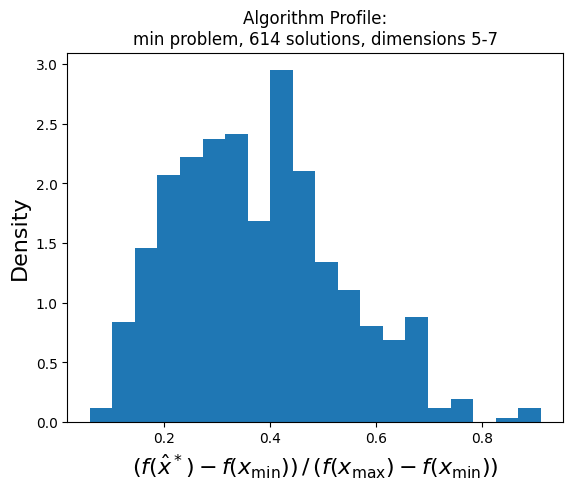

In [74]:
plt.hist(df.performance,density=True,bins=20)
plt.title('Algorithm Profile:\n{} problem, {} solutions, dimensions {}-{}'.\
          format(opt,solution_good,min(df.dimension),max(df.dimension)))
plt.xlabel(r'$(f(\hat{x}^*)-f(x_\min))\,/\,(f(x_\max)-f(x_\min))$',fontsize=16)
plt.ylabel(r'Density',fontsize=16)
plt.show()

In [75]:
print('Mean Performance: {:.2f}'.format(df.performance.mean()))
print('Median Performance: {:.2f}'.format(df.performance.median()))
print('Distribution Modal: {:.2f}'.format(find_modal(df[~df.performance.isna()].performance)[0]))

Mean Performance: 0.38
Median Performance: 0.36
Distribution Modal: 0.41


# Probability

Using the score density, we can estimate the probability 

$$Pr[f(\hat{\mathbf{x}}^*) - f(\mathbf{x}_{\min})<  \epsilon \cdot (f(\mathbf{x}_{\max})-f(\mathbf{x}_{\min}))]$$

of the OCL algorithm to hit the true optimum. 

In [76]:
kde = gaussian_kde(df[~df.performance.isna()].performance)

epsilon = 0.4

print('Estimated performance probability: {:.2f}'.format(kde.integrate_box_1d(0,epsilon)))

Estimated performance probability: 0.58
